In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from scipy.signal import find_peaks
from scipy import sparse
from scipy.sparse.linalg import spsolve
from lmfit.models import GaussianModel
# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


In [ ]:
def integrate_s2(file, s2_lowcut=0.5e-5, s2_upcut=1.5e-5):
    wf = wfm2read(file)
    t, V = wf[1], -wf[0]
    
    bs_lowcut = 2e-5
    bs_upcut = 4e-5
    baseline_window = (t > bs_lowcut) & (t < bs_upcut)
    baseline = np.mean(V[baseline_window])
    V -= baseline

    s2_window = (t > s2_lowcut) & (t < s2_upcut)
    area_s2 = np.trapz(V[s2_window], t[s2_window]) * 1e6 / 1e-3  # Convert to milivolts / microsec
    return area_s2, V, t

def plot_s2_integration(t, V, s2_lowcut, s2_upcut, trig_x = None, trig_y = None):

    plt.plot(t, V, label='SCA Waveform')
    if trig_x is not None and trig_y is not None:
        plt.plot(trig_x, trig_y, label='Trigger SCA', color='orange')

    plt.fill_betweenx(
        [0, 1],
        x1=s2_lowcut,
        x2=s2_upcut,
        color='green',
        alpha=0.3,
        label='S2 window'
    )
    plt.gca().set(xlabel='Time (s)', ylabel='Voltage (V)', title='SCA Waveform with Trigger')

def extract_s2_areas(files):
    areas = []
    for f in files:
        as2, V, t = integrate_s2(f)
        areas.append(as2)
    return np.array(areas)

def apply_hist_cuts(arr, lowcut, upcut):
    return arr[(arr > lowcut) & (arr < upcut)]

def fit_gaussian(data, bins=150):
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    model = GaussianModel()
    params = model.guess(hist, x=bin_centers)
    result = model.fit(hist, params, x=bin_centers)
    
    return result, bin_centers

# S2 analysis

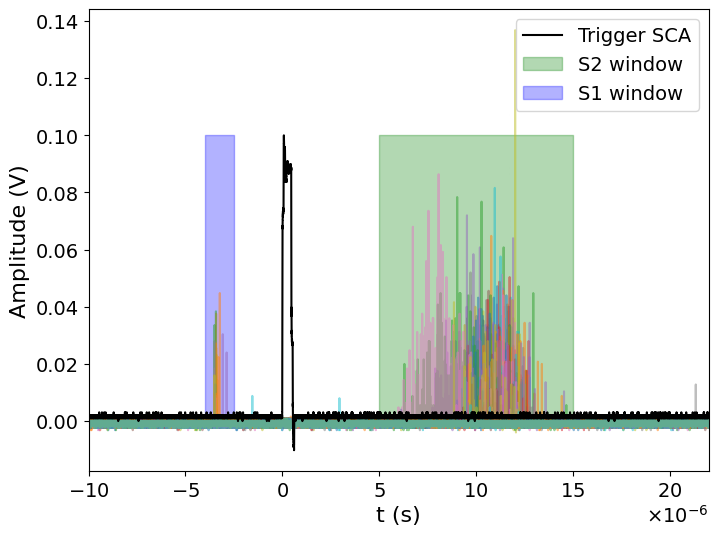

In [63]:
path21 = r'/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/VoltageScans/VoltageScan_5GSsec_EL2100_Gate700/*.wfm'
files21 = sorted(glob(path21))
plt.figure(figsize=(8, 6))
for f in files21[:50]:
    wf = wfm2read(f)
    y, t = -wf[0], wf[1]
    plt.plot(t, y, alpha=0.5)

plt.plot(trig_x, trig_y, label='Trigger SCA', color='black')
plt.fill_betweenx(
        [0, 0.1],
        x1=s2_lowcut, x2=s2_upcut,
        color='green', alpha=0.3, label='S2 window'
    )

s1_lowcut = -0.4e-5
s1_upcut = -0.25e-5
plt.fill_betweenx(
        [0, 0.1],
        x1=s1_lowcut, x2=s1_upcut,
        color='blue', alpha=0.3, label='S1 window'
    )


plt.gca().set(xlim=(-1e-5, 2.2e-5), xlabel='t (s)', ylabel='Amplitude (V)')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))

# Anode voltage scan
Gate fixed at 700 V

In [6]:
trigger_file = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/sca_waveform.wfm'
trig = wfm2read(trigger_file, verbose=False)
trig_x, trig_y = trig[1], trig[0]
trig_y = trig_y / (10 * np.max(trig_y))

# Define voltage values for scan
voltages_el = ['2100', '2600', '3100', '3600']

# Build paths and file lists using a loop
base_path_el = r'/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/VoltageScans/VoltageScan_5GSsec_EL{}_Gate700/*.wfm'
voltage_files_el = {}
for v in voltages_el:
    path = base_path_el.format(v)
    files = sorted(glob(path))
    voltage_files_el[v] = files
    print(f"Voltage {v}V: {len(files)} files")

# For compatibility with previous cells, you can still assign:
files21 = voltage_files_el['2100']
files26 = voltage_files_el['2600']
files31 = voltage_files_el['3100']
files36 = voltage_files_el['3600']

Voltage 2100V: 3000 files
Voltage 2600V: 3000 files
Voltage 3100V: 3000 files
Voltage 3600V: 3000 files


In [7]:
# Define voltage scan groups and their file lists
voltage_groups_el = {
    '2100': files21,
    '2600': files26,
    '3100': files31,
    '3600': files36
}

s2_lowcut = 0.5e-5
s2_upcut = 1.5e-5
hist_lowcut = -10
hist_upcut = 20


# Process all voltage groups
s2_areas_el = {}
s2_areas_cuts_el = {}
for v, files in voltage_groups_el.items():
    arr = extract_s2_areas(files)
    s2_areas_el[v] = arr
    s2_areas_cuts_el[v] = apply_hist_cuts(arr, hist_lowcut, hist_upcut)

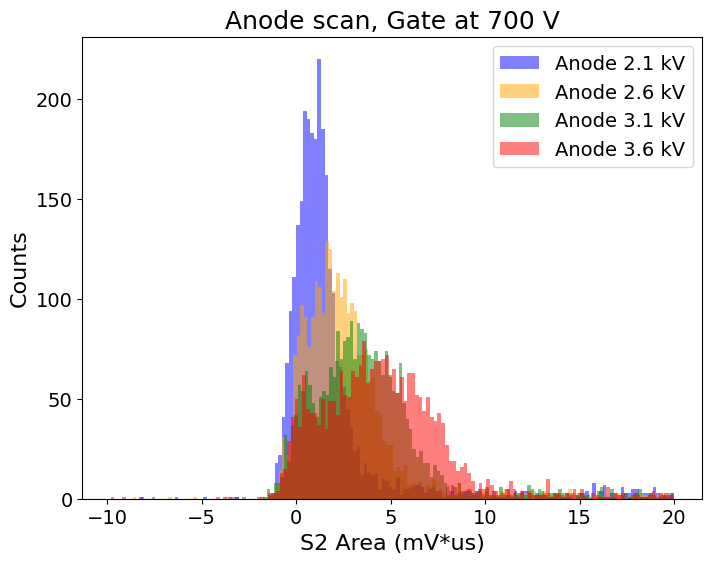

In [8]:
plt.figure(figsize=(8, 6))
for v, label, color in zip(['2100', '2600', '3100', '3600'],
                              ['Anode 2.1 kV', 'Anode 2.6 kV', 'Anode 3.1 kV', 'Anode 3.6 kV'],
                              ['blue', 'orange', 'green', 'red']):
    plt.hist(s2_areas_cuts_el[v], bins=150, alpha=0.5, label=label, color=color)

plt.gca().set(xlabel='S2 Area (mV*us)', ylabel='Counts', title='Anode scan, Gate at 700 V')
plt.legend()

## Plot EL 3.1 kV, Gate 700 V and fit to double gaussian

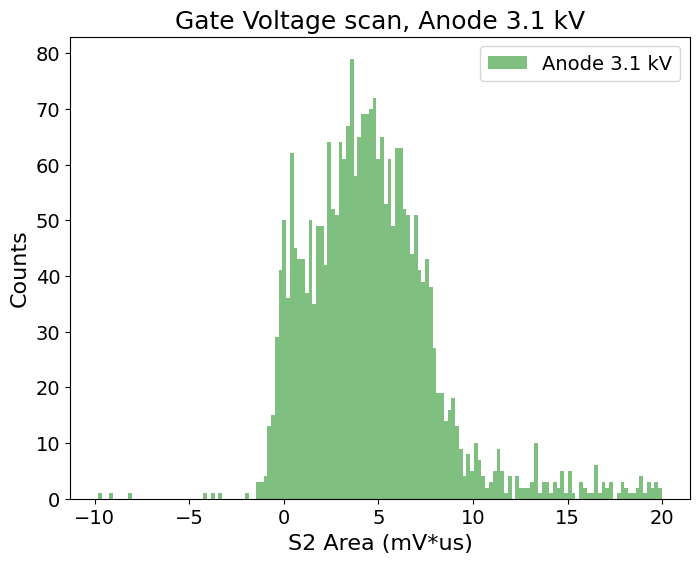

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(s2_areas_cuts_el['3600'], bins=150, alpha=0.5, label='Anode 3.1 kV', color='green');
plt.gca().set(xlabel='S2 Area (mV*us)', ylabel='Counts', title='Gate Voltage scan, Anode 3.1 kV');
plt.legend()

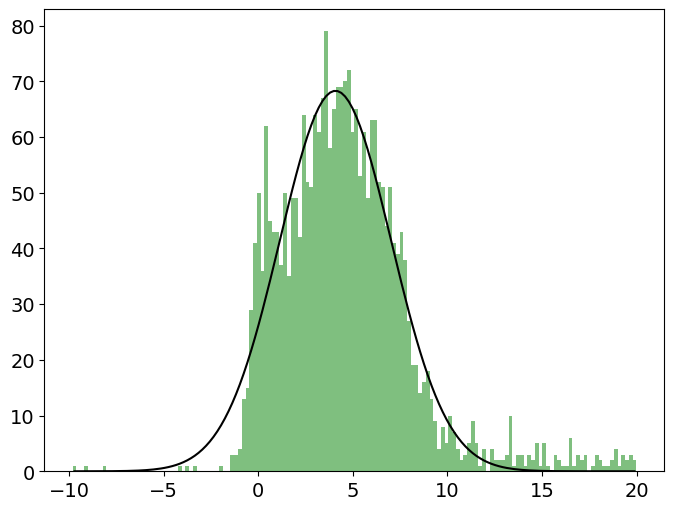

In [51]:
# Fit Gaussian to the S2 area distribution for 3.6 kV

fit_result_3600, binc = fit_gaussian(s2_areas_cuts_el['3600'])
x_fit = np.linspace(binc[0], binc[-1], len(binc))
plt.figure(figsize=(8, 6))
plt.hist(s2_areas_cuts_el['3600'], bins=150, alpha=0.5, label='Anode 3.6 kV', color='green')
plt.plot(x_fit, fit_result_3600.best_fit, label='Gaussian Fit', color='black')

In [54]:
fit_result_3600

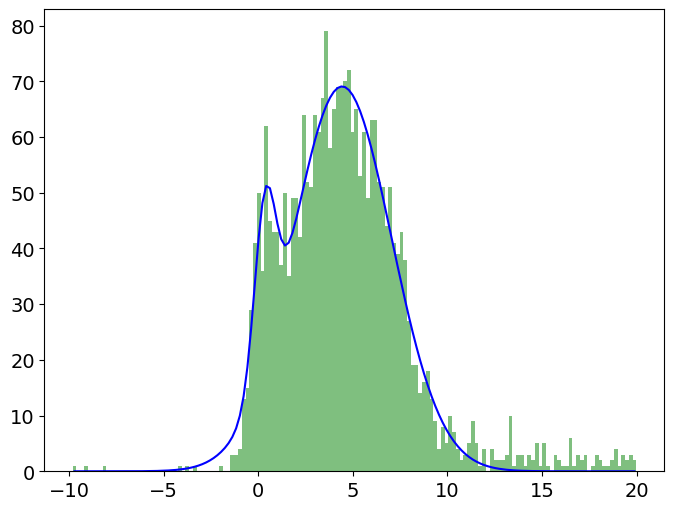

In [61]:
# Fit Gaussian to the S2 area distribution for 3.6 kV
data = s2_areas_cuts_el['3600']

hist, bin_edges = np.histogram(data, bins=150)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

model = GaussianModel(prefix='g1_') + GaussianModel(prefix='g2_')
model.set_param_hint('g1_amplitude', value=np.max(hist) * 0.25, min=0)
model.set_param_hint('g2_amplitude', value=np.max(hist) * 0.25, min=0)
model.set_param_hint('g1_center', value=np.mean(data), min=2, max=np.max(data))
model.set_param_hint('g2_center', value=np.mean(data) - 2, min=np.min(data), max=2)
model.set_param_hint('g1_sigma', value=np.std(data) * 0.5, min=0)
model.set_param_hint('g2_sigma', value=np.std(data) * 0.45, min=0)
params = model.make_params()
result = model.fit(hist, params, x=bin_centers)

x_fit = np.linspace(binc[0], binc[-1], len(binc))
plt.figure(figsize=(8, 6))
plt.hist(s2_areas_cuts_el['3600'], bins=150, alpha=0.5, label='Anode 3.6 kV', color='green')
plt.plot(x_fit, result.best_fit, label='Gaussian Fit', color='b')

In [62]:
result

# Gate voltage scan:
Anode fixed at 3100 V

In [74]:
trigger_file = r'E:\Pablos_Mighty_measurements\RUN1\GasCirculation_5GSsec_TriggerSCA_EL2100V\sca_waveform.wfm'
trig = wfm2read(trigger_file, verbose=False)
trig_x, trig_y = trig[1], trig[0]
trig_y = trig_y / (10 * np.max(trig_y))

# Define voltage values for scan
voltages = ['700', '1200', '1700', '2200', '2700']

# Build paths and file lists using a loop
base_path = r'E:\Pablos_Mighty_measurements\RUN1\VoltageScan_5GSsec_EL3100_Gate{}\\*.wfm'
voltage_files = {}
for v in voltages:
    path = base_path.format(v)
    files = sorted(glob(path))
    voltage_files[v] = files
    print(f"Voltage {v}V: {len(files)} files")

# For compatibility with previous cells, you can still assign:
files07 = voltage_files['700']
files12 = voltage_files['1200']
files17 = voltage_files['1700']
files22 = voltage_files['2200']
files27 = voltage_files['2700']

Voltage 700V: 3000 files
Voltage 1200V: 3000 files
Voltage 1700V: 3000 files
Voltage 2200V: 3000 files
Voltage 2700V: 3000 files


In [75]:
# Define voltage scan groups and their file lists
voltage_groups = {
    '700': files07,
    '1200': files12,
    '1700': files17,
    '2200': files22,
    '2700': files27
}

s2_lowcut = 0.5e-5
s2_upcut = 1.5e-5
hist_lowcut = -5
hist_upcut = 20


# Process all voltage groups
s2_areas = {}
s2_areas_cuts = {}
for v, files in voltage_groups.items():
    arr = extract_s2_areas(files)
    s2_areas[v] = arr
    s2_areas_cuts[v] = apply_hist_cuts(arr, hist_lowcut, hist_upcut)

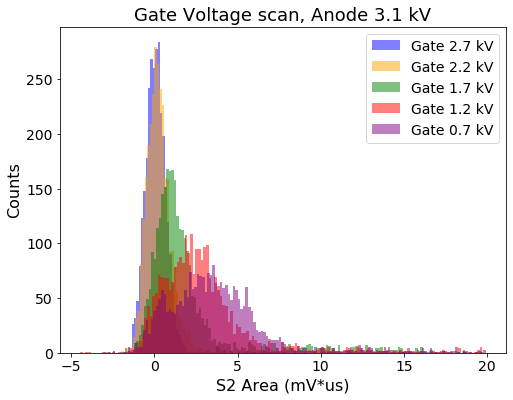

In [76]:
plt.figure(figsize=(8, 6))
for v, label, color in zip(['2700', '2200', '1700', '1200', '700'],
                              ['Gate 2.7 kV', 'Gate 2.2 kV', 'Gate 1.7 kV', 'Gate 1.2 kV', 'Gate 0.7 kV'],
                              ['blue', 'orange', 'green', 'red', 'purple']):
    plt.hist(s2_areas_cuts[v], bins=150, alpha=0.5, label=label, color=color)

plt.gca().set(xlabel='S2 Area (mV*us)', ylabel='Counts', title='Gate Voltage scan, Anode 3.1 kV')
plt.legend()

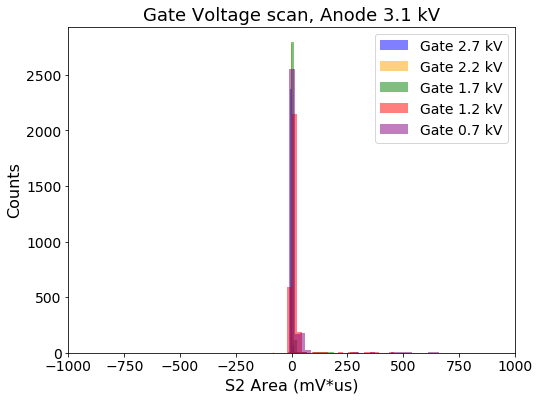

In [73]:
plt.figure(figsize=(8, 6))
for v, label, color in zip(['2700', '2200', '1700', '1200', '700'],
                              ['Gate 2.7 kV', 'Gate 2.2 kV', 'Gate 1.7 kV', 'Gate 1.2 kV', 'Gate 0.7 kV'],
                              ['blue', 'orange', 'green', 'red', 'purple']):
    plt.hist(s2_areas[v], bins=100, alpha=0.5, label=label, color=color)

plt.gca().set(xlabel='S2 Area (mV*us)', ylabel='Counts', xlim=(-1000, 1000),
               title='Gate Voltage scan, Anode 3.1 kV')
plt.legend()

# S2 rate

## Anode scan

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Voltage (V)'),
 Text(0.5, 1.0, 'SCA Waveform with S2 Window')]

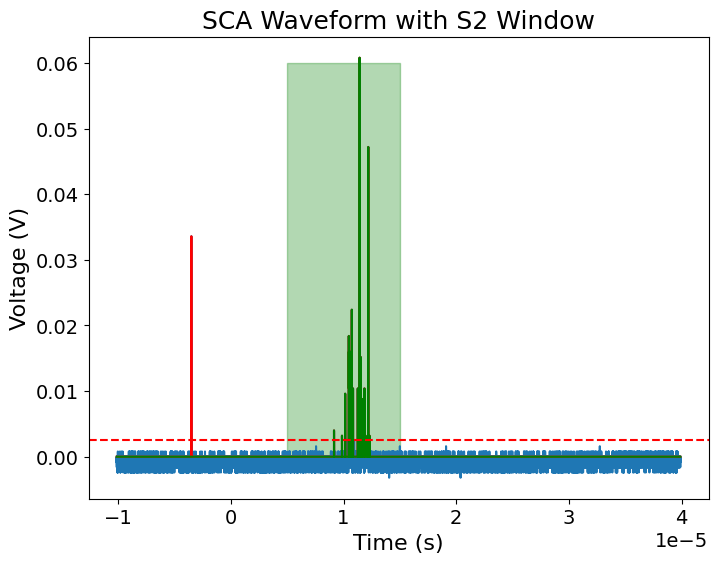

In [88]:
wf = wfm2read(files21[2])
y, t = -wf[0], wf[1]
plt.figure(figsize=(8, 6))
plt.plot(t, y, label='SCA Waveform')

cutV = 0.0025
ycut = np.where(y > cutV, y, 0)
s2_window = np.where((t > s2_lowcut) & (t < s2_upcut), ycut, 0)
plt.plot(t, ycut, label='SCA Waveform Cut', color='red')
plt.plot(t, s2_window, label='S2 Window', color='green')
plt.axhline(cutV, color='red', linestyle='--', label='Cut Voltage')
plt.fill_betweenx(
    [0, 0.06],
    x1=s2_lowcut, x2=s2_upcut,
    color='green', alpha=0.3, label='S2 window'
)
plt.gca().set(xlabel='Time (s)', ylabel='Voltage (V)',
               title='SCA Waveform with S2 Window')
# plt.plot(trig_x, trig_y, label='Trigger SCA', color='orange')

In [92]:
def check_s2(file, cutV = 0.0025, s2_lowcut=0.5e-5, s2_upcut=1.5e-5):
    wf = wfm2read(file)
    y, t = -wf[0], wf[1]

    ycut = np.where(y > cutV, y, 0)
    s2_window = np.where((t > s2_lowcut) & (t < s2_upcut), ycut, 0)
    s2_flag = (s2_window > 0).any()
    return s2_flag

In [96]:
def get_s2_rate(files):
    s2_flags = []
    for f in files:
        s2_flags.append(check_s2(f))
    s2_flags = np.array(s2_flags)
    rate_s2s = s2_flags.sum() / len(files21)
    return rate_s2s

In [97]:
get_s2_rate(files21), get_s2_rate(files26), get_s2_rate(files31), get_s2_rate(files36)

(0.9243333333333333, 0.9486666666666667, 0.947, 0.951)